In [1]:
import os

import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from PIL import Image
import pickle

import image

In [10]:
def show_sp_regions(sp_regions, borders=True):
    if len(sp_regions) == 0:
        return
    ax = plt.gca()
    # ax.set_autoscale_on(False)

    img = np.ones((sp_regions.shape[1], sp_regions.shape[2], 4))
    img[:, :, 3] = 0
    for i in range(sp_regions.shape[0]):
        m = sp_regions[i,:,:]
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1) 

    ax.imshow(img)

In [2]:
with open('../data/kfs_moge_realsense/kf_1.pkl', 'rb') as file:
    data = pickle.load(file)

In [45]:
image_raw = data['state_dict']['image_raw'].cpu().permute(1,2,0)
sp_regions = data['state_dict']['sp_regions'].cpu().numpy()

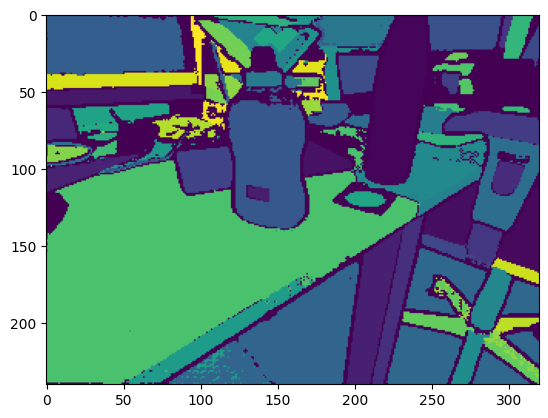

In [82]:
integer_segments = np.zeros([sp_regions.shape[1], sp_regions.shape[2]])
union_mask = np.zeros([sp_regions.shape[1], sp_regions.shape[2]])
for i in range(sp_regions.shape[0]):
    union_mask = np.logical_or(union_mask, sp_regions[i,:,:,])
    integer_segments[sp_regions[i,:,:]] = i + 1
plt.imshow(integer_segments)

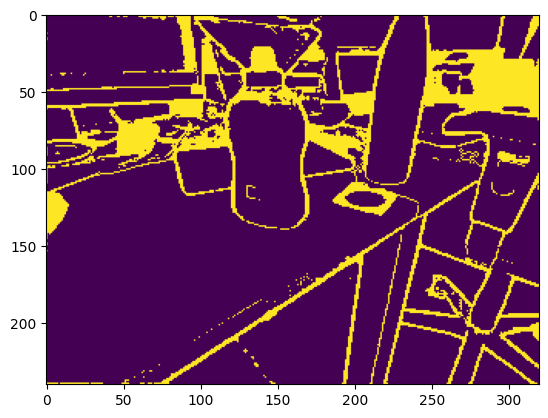

In [ ]:
union_mask = np.logical_not(union_mask)
plt.imshow(union_mask)

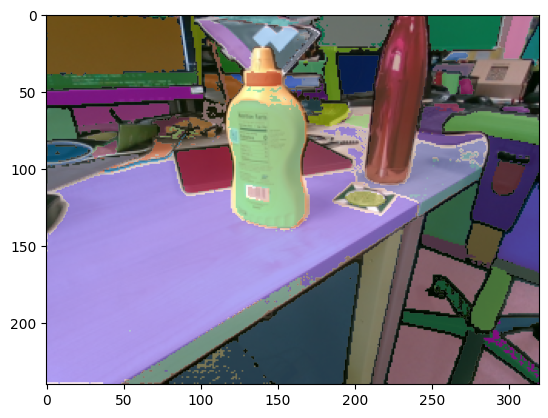

In [51]:
plt.imshow(image_raw)
show_sp_regions(sp_regions, borders=False)

odict_keys(['image_raw', 'raymap', 'raydist', 'log_raydist', 'pointmap', 'sp_regions', 'K', 'keypoints', 'region_corr', 'original_image'])
torch.Size([240, 320, 3])
torch.Size([80, 240, 320])


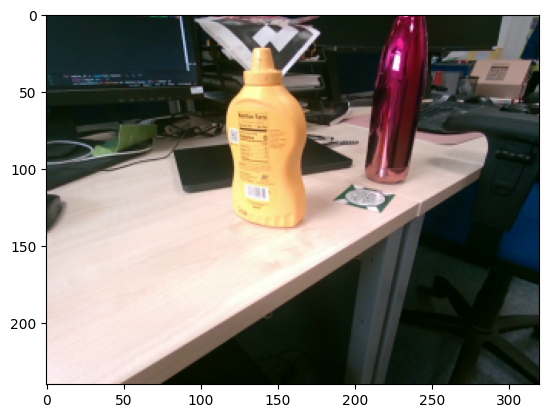

In [5]:
state_dict = data['state_dict']
print(state_dict.keys())
plt.imshow(state_dict['image_raw'].cpu().permute(1, 2, 0))
print(state_dict['pointmap'].shape)
print(state_dict['sp_regions'].shape)

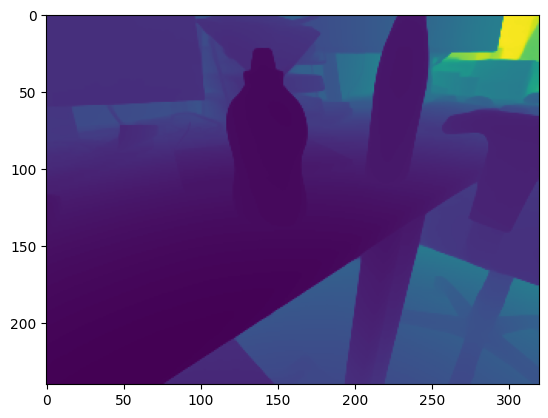

In [25]:
plt.imshow(state_dict['raydist'].cpu())

In [64]:
def quadto2tris(idx: tuple, verts: np.ndarray) -> tuple[list[int], list[int]]:
    """Decides which two triangles to construct from the quadrilateral provided"""
    
    diag1_len_sq = np.sum((verts[0] - verts[2])**2)
    diag2_len_sq = np.sum((verts[1] - verts[3])**2)
    
    if diag1_len_sq <= diag2_len_sq:
        tri1 = [idx[0], idx[2], idx[1]]
        tri2 = [idx[0], idx[3], idx[2]]
    else:
        tri1 = [idx[0], idx[3], idx[1]]
        tri2 = [idx[1], idx[3], idx[2]]
    
    return (tri1, tri2)

In [87]:
from trimesh import Trimesh
verts = state_dict['pointmap'].cpu().reshape(-1, 3)
tris = []
H, W = 240, 320
for v in range(H - 1):
    for u in range(W - 1):
        id_tl = v * W + u
        id_tr = id_tl + 1
        id_bl = id_tl + W
        id_br = id_bl + 1

        quad_idx = (id_bl, id_tl, id_tr, id_br)
        quad_verts = np.array([verts[id] for id in quad_idx])

        sps = [integer_segments.flatten()[id] for id in quad_idx]
        sp_counts = {}
        for sp in sps:
            sp_counts[sp] = 1 + sp_counts.get(sp, 0)

        if len(sp_counts) == 1 and sps[0] != 0: # All verts from one sp
            tri1, tri2 = quadto2tris(quad_idx, quad_verts)
            tris.extend([tri1, tri2])
        elif len(sp_counts) == 2 and len(set(sp_counts.values())) == 2: # Three verts from one sp, one from another
            aclock_quad_idx = list(quad_idx)
            for i in range(4):
                if sp_counts[sps[i]] == 1:
                    del aclock_quad_idx[i]
            if integer_segments.flatten()[aclock_quad_idx[0]] == 0:
                continue # Skip this triangle if it is not in a superprimitive
            aclock_quad_idx.reverse()
            tris.append(aclock_quad_idx)

mesh = Trimesh(vertices=verts, faces=tris)

In [88]:
mesh.show()

In [3]:
def infer_pointmap_scales(raymap,
                          log_raydist,
                          sp_regions,
                          sp_logscales,
                          global_logscale=None):
    # raymap (H, W, 3) is the raymap
    # log_raydist (H, W) is the log ray distance
    # sp_regions are [N_segments, H, W] is the segment regions
    # sp_logscales (N_segments) is the log scale of the segments
 
    num_segments, H, W = sp_regions.shape
 
    assert(torch.isfinite(sp_logscales).all())
    assert(sp_logscales.shape[0] == num_segments)
 
    
    if global_logscale is not None:
        sp_logscales = sp_logscales + global_logscale
 
    raydist_shifts = sp_logscales.unsqueeze(-1).unsqueeze(-1)
    raydist_shifts = raydist_shifts.expand(-1, H, W)
 
    # assumed here that the keypoint regions are disjoint
    raydist_shifts = raydist_shifts * sp_regions
    raydist_shifts = raydist_shifts.sum(dim=0)
    assert(torch.isfinite(raydist_shifts).all())  
 
 
    final_raydist = log_raydist + raydist_shifts
    # final_raydist is (H, W) and is in log space
 
    pointmap = torch.exp(final_raydist).unsqueeze(-1) * raymap
 
    return pointmap

In [1]:
def invalid_borders_mask(H, W, device='cuda:0'):
    y, x = torch.meshgrid(torch.arange(H, device=device), 
                          torch.arange(W, device=device), indexing='ij')
    coords = torch.stack((y, x), dim=-1).reshape(-1, 2)

    grid = point_utils.normalise_coordinates(coords, (H, W))
    valid_grid = grid.abs().max(dim=-1).values < 0.99  

    return valid_grid.reshape(H, W)

def spatial_size(pointmap):
    # pointmap is [..., 3]
    assert(pointmap.shape[-1] == 3)
    return pointmap.shape[:-1]

def create_opt_params(kf, deformable, dtype=torch.float32, pose_dtype=torch.float32):
    global_logdepth_init = 0.0
    # _, H, W = kf.image.shape
    device = kf.image.device
    
    num_segments = kf.num_segments()

    global_logscale =  torch.tensor([global_logdepth_init], device=device, dtype=dtype)
    segment_logscales =  torch.zeros(num_segments, device=device, dtype=dtype)

 
    kf_opts = {'sp_logscales': segment_logscales,
               'global_logscale': global_logscale}

    kf_deforms = None
    if deformable:
        kf_deforms = torch.eye(4, device=device,
                               dtype=pose_dtype).unsqueeze(0).expand(num_segments,
                                                                                          -1, -1)
        
    return kf_opts, kf_deforms  


def infer_raymap(pointmap, eps=1e-7):
    # pointmaps is [..., 3]
    assert(pointmap.shape[-1] == 3)
    raydist = torch.norm(pointmap, dim=-1, keepdim=True)

    raymap = pointmap / (raydist + eps)

    return raymap, raydist.squeeze(-1)

class PointmapKF(nn.Module):
    def __init__(self, 
                 image, 
                 pointmap, 
                 sp_regions, 
                 region_corr=None,
                 keypoints=None,
                 K=None,
                 original_image=None,
                 **kwargs):
        super().__init__()

        with torch.no_grad():
            raymap, raydist = infer_raymap(pointmap)

        self.register_buffer('image_raw', image)
        self.register_buffer('raymap', raymap)
        self.register_buffer('raydist', raydist)
        self.register_buffer('log_raydist', torch.log(raydist))
        self.register_buffer('pointmap', pointmap)
        self.register_buffer('sp_regions', sp_regions)

        if K is not None:
            self.register_buffer('K', K)
        if keypoints is not None:
            self.register_buffer('keypoints', keypoints)
        if region_corr is None:
            self.register_buffer('region_corr', region_corr)

        if original_image is not None:
            self.register_buffer('original_image', original_image)

        self._remove_empty_segments()
        # self._original_image = original_image

    @property
    def original_image(self):
        if self._original_image is not None:
            return self._original_image
        return self.image_raw
    
    @property
    def image(self):
        if self.image_raw.shape[0] > 3:
            return self.image_raw[:3]
        return self.image_raw

    def has_normals(self):
        return self.image_raw.shape[0] > 3
    
    @property
    def image_normals(self):
        if self.image_raw.shape[0] > 3:
            return self.image_raw[3:]
        return None
    
    @property
    def normals(self):
        if self.image_raw.shape[0] > 3:
            return self.image_raw[3:]
        return None
    
    def num_segments(self):
        return self.sp_regions.shape[0]
    
    def spatial_size(self):
        return spatial_size(self.raymap)


    def _remove_empty_segments(self):
        H, W = self.spatial_size()
        valid_grid = invalid_borders_mask(H, W, device=self.sp_regions.device)
        masks_padd = (self.sp_regions & valid_grid[None, ...])

        num_valid_pix = (masks_padd).sum(dim=(1, 2))
        good_masks = num_valid_pix > 0

        self.sp_regions = self.sp_regions[good_masks]
        return

NameError: name 'torch' is not defined